In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import san
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# not using this at this time
from keys import KEY
san.ApiConfig.api_key = KEY

---

# IMPORTANT GET THE DATA

In [18]:
import san
# san.ApiConfig.api_key = 'xauqgnp4uvwk4u7c_a5x7oyk6zj5bcyzn'
san.ApiConfig.api_key ='6mglxjgy7dl3mzux_55jpklyowrzdfaum'

In [111]:
# search for available metric in api, given slug (aka token) and search term
def search_metric(slug,search_term):
    metric_list = []
    santiment = san.available_metrics_for_slug(slug)
    for i in santiment:
        if search_term in i:
            metric_list.append(i)
    return metric_list

In [122]:
# Running as single func (project, term)
search_metric('chainlink','price')

['daily_avg_price_usd',
 'daily_closing_price_usd',
 'daily_high_price_usd',
 'daily_low_price_usd',
 'daily_opening_price_usd',
 'mean_realized_price_usd',
 'mean_realized_price_usd_10y',
 'mean_realized_price_usd_180d',
 'mean_realized_price_usd_1d',
 'mean_realized_price_usd_2y',
 'mean_realized_price_usd_30d',
 'mean_realized_price_usd_365d',
 'mean_realized_price_usd_3y',
 'mean_realized_price_usd_5y',
 'mean_realized_price_usd_60d',
 'mean_realized_price_usd_7d',
 'mean_realized_price_usd_90d',
 'price_btc',
 'price_eth',
 'price_usd',
 'price_usd_5m',
 'price_usd_change_1d',
 'price_usd_change_30d',
 'price_usd_change_7d']

In [ ]:
san.available_metric_for_slug_since(metric='active_deposits', slug='chainlink')

In [4]:
def get_metric_complexity(request, from_date='2018-07-31', to_date='2020-07-30',interval='1h'):
    df = san.metric_complexity(
        f'{request}',
        from_date=from_date,
        to_date=to_date,
        interval=interval
    )
    print(f'complexity score: {df}')
    return f'Too complex for free plan: {df > 20000}' 

In [131]:
san.metric_complexity(
    metric='daily_closing_price_usd',
    from_date='2018-07-31',
    to_date='2020-07-30',
    interval='1h'
)

10526

In [144]:
get_metric_complexity('daily_closing_price_usd',from_date='2015-01-01')

complexity score: 58694


'Too complex for free plan: True'

In [5]:
# This allows to create a ts df for a given metric
def get_metric_timeseries(request, asset,from_date='2018-07-31', to_date='2020-07-30',interval='1d'):
    df = san.get(
        f'{request}/{asset}',
        from_date=from_date,
        to_date=to_date,
        interval=interval
    )
    # if no col named value, renaming ignored
    df = df.rename(columns={'value':f'{asset}_{request}'})
    return df

In [6]:
# This can be improved to include more df (*args)
# This allows to .join timeseries dfs on common index (datetime)
def aggregate_timeseries_df(df,df1,d2):
    # join df on indexes (datetime)
    df = df.join(df1).join(df2)
    return df

In [7]:
# FUNCTION FOR NON TIMESERIES REQUESTS
def get_nonts_metric(request='projects',requestgroup='all'):
    df = san.get(
        f'{request}/{requestgroup}'
    )
    return df

In [8]:
# FUNCTION TO AGG NON TIMESERIES
# This can be improved to include more df (*args)
# This allows to .join timeseries dfs on common index (datetime)
def aggregate_nonts_df(df,df1):
    # join df on indexes (datetime)
    df = df.join(df1, lsuffix='left')
    return df

In [19]:
df = get_metric_timeseries('prices','chainlink')
df.head()

,marketcap,priceBtc,priceUsd,volume
datetime,,,,
2018-07-31 00:00:00+00:00,102876899.0,0.000038,0.293934,2272300.0
2018-08-01 00:00:00+00:00,100548000.0,0.000038,0.287280,1546730.0
2018-08-02 00:00:00+00:00,108353000.0,0.000041,0.309580,1954190.0
2018-08-03 00:00:00+00:00,99707928.0,0.000038,0.284880,1460135.0
2018-08-04 00:00:00+00:00,90296150.0,0.000037,0.257989,1284510.0


In [20]:
df = get_nonts_metric()
df1 = get_nonts_metric(requestgroup='erc20')
#df2 = get_nontimeseries_metric(requestgroup='erc20')

dfs = aggregate_timeseries_df(df,df1)
dfs.head()

TypeError: aggregate_timeseries_df() missing 1 required positional argument: 'd2'

In [21]:
# GETTING DATAFRAMES AND JOINING THEM
df = get_metric_timeseries('ohlcv', 'chainlink')
df1 = get_metric_timeseries('daily_active_addresses', 'chainlink')
df2 = get_metric_timeseries('active_deposits', 'chainlink')
df_agg = aggregate_timeseries_df(df,df1,df2)
df_agg.describe()

,openPriceUsd,closePriceUsd,highPriceUsd,lowPriceUsd,volume,marketcap,chainlink_daily_active_addresses,chainlink_active_deposits
count,731.000000,731.000000,731.000000,731.000000,7.310000e+02,7.310000e+02,731.000000,69.000000
mean,1.956626,1.966422,2.045263,1.881847,1.516085e+08,6.882476e+08,1543.406293,375.623188
std,1.672231,1.683669,1.741221,1.613389,2.049057e+08,5.892843e+08,1829.012944,224.320812
min,0.203568,0.202932,0.207196,0.196525,4.300080e+05,7.102615e+07,63.000000,183.000000
25%,0.452104,0.452108,0.471789,0.433148,5.099016e+06,1.582377e+08,186.000000,225.000000
50%,1.836896,1.838879,1.904876,1.776874,7.109971e+07,6.436076e+08,1085.000000,270.000000
75%,2.774188,2.779406,2.866623,2.673228,2.195484e+08,9.727921e+08,2139.000000,446.000000
max,8.640430,8.643123,8.754881,8.216572,1.478593e+09,3.025093e+09,14253.000000,1345.000000


In [22]:
df = get_metric_timeseries('prices', 'chainlink', interval='1h')

SanError: GraphQL error occured running query {
    query_0: historyPrice(
        slug: "chainlink",
        from: "2018-07-31T00:00:00+00:00",
        to: "2020-07-30T23:59:59+00:00",
        interval: "1h"
    ){
    datetime priceUsd priceBtc marketcap volume}} 
 errors: [{'locations': [{'column': 5, 'line': 2}], 'message': 'Field historyPrice is too complex: complexity is 87720 and maximum is 20000'}, {'locations': [{'column': 1, 'line': 1}], 'message': 'Operation is too complex: complexity is 87720 and maximum is 20000'}]

## Data cleaning/manipulating

In [ ]:
df_agg['price_volume'] = df_agg.priceUsd/df_agg.volume
df_agg.head()

In [ ]:
#df_agg.drop(columns='price_volume', inplace=True)
df_agg.head()

In [ ]:
df_agg.dtypes

In [23]:
# OLD
# BETTER ACHIEVED IN DF SERIES get_metric_timeseries() CALL

from_date = '2018-07-31'
to_date = '2020-07-30'
asset = 'chainlink'
interval = '1d'

# get unique active addresses on-chain
# https://academy.santiment.net/sansheets/functions/#san_active_addresses 
daa = san.get(
    f'daily_active_addresses/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)

price = san.get(
    f'prices/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval
)

# trans = san.get(
#     f'transaction_volume/{asset}',
#     from_date=from_date,
#     to_date=to_date,
#     interval=interval    
# )

dep = san.get(
    f'active_deposits/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval    
)

# execute the request
#[daa, dad, price] = batch.execute()

# merge dataframes
data = daa.rename(columns={'value':f'{asset}_activeAddresses'}).join(dep.rename(columns={'value':f'{asset}_activeDepositAddresses'})).join(price[['priceUsd','volume']])

# take a look
data.tail()

,chainlink_activeAddresses,chainlink_activeDepositAddresses,priceUsd,volume
datetime,,,,
2020-07-26 00:00:00+00:00,6894.0,546.0,7.499005,693139972.0
2020-07-27 00:00:00+00:00,9176.0,831.0,7.095583,921616285.0
2020-07-28 00:00:00+00:00,6252.0,475.0,7.223460,592707771.0
2020-07-29 00:00:00+00:00,5407.0,403.0,7.116083,577077884.0
2020-07-30 00:00:00+00:00,5013.0,385.0,7.416992,605829268.0


In [24]:
pd.isnull(data).sum()

chainlink_activeAddresses             0
chainlink_activeDepositAddresses    662
priceUsd                              0
volume                                0
dtype: int64

In [25]:
data.shape

(731, 4)

In [26]:
data.dtypes

chainlink_activeAddresses           float64
chainlink_activeDepositAddresses    float64
priceUsd                            float64
volume                              float64
dtype: object

In [27]:
from_date = '2018-07-31'
to_date = '2020-07-30'
asset = 'chainlink'
interval = '1d'

trade = san.get(
    f'daily_trading_volume_usd/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval    
)

trade.head()

,value
datetime,
2018-07-31 00:00:00+00:00,2272300.0
2018-08-01 00:00:00+00:00,1546730.0
2018-08-02 00:00:00+00:00,1954190.0
2018-08-03 00:00:00+00:00,1460135.0
2018-08-04 00:00:00+00:00,1284510.0


In [28]:
from_date = '2018-07-31'
to_date = '2020-07-30'
asset = 'chainlink'
interval = '1d'

trans = san.get(
    f'active_deposits/{asset}',
    from_date=from_date,
    to_date=to_date,
    interval=interval    
)

trans.head()

,value
datetime,
2020-05-23 00:00:00+00:00,242.0
2020-05-24 00:00:00+00:00,244.0
2020-05-25 00:00:00+00:00,230.0
2020-05-26 00:00:00+00:00,236.0
2020-05-27 00:00:00+00:00,210.0


In [29]:
trans.shape

(69, 1)

<AxesSubplot:xlabel='datetime'>

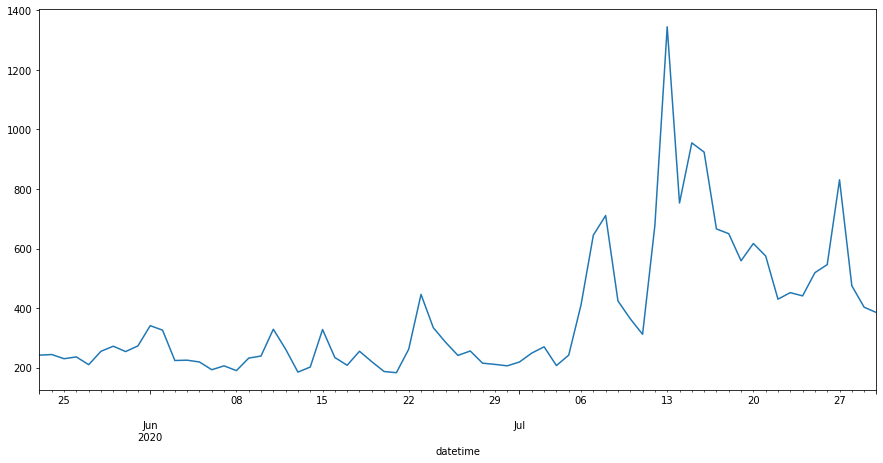

In [30]:
trans['value'].plot(figsize=(15,7))

In [31]:
data['transactionVol'].tail()

KeyError: 'transactionVol'

In [32]:
pd.isnull(data).sum()

chainlink_activeAddresses             0
chainlink_activeDepositAddresses    662
priceUsd                              0
volume                                0
dtype: int64

In [33]:
data.describe()

,chainlink_activeAddresses,chainlink_activeDepositAddresses,priceUsd,volume
count,731.000000,69.000000,731.000000,7.310000e+02
mean,1543.406293,375.623188,1.966422,1.516085e+08
std,1829.012944,224.320812,1.683669,2.049057e+08
min,63.000000,183.000000,0.202932,4.300080e+05
25%,186.000000,225.000000,0.452108,5.099016e+06
50%,1085.000000,270.000000,1.838879,7.109971e+07
75%,2139.000000,446.000000,2.779406,2.195484e+08
max,14253.000000,1345.000000,8.643123,1.478593e+09


In [34]:
data.corr()

,chainlink_activeAddresses,chainlink_activeDepositAddresses,priceUsd,volume
chainlink_activeAddresses,1.000000,0.885067,0.901723,0.931611
chainlink_activeDepositAddresses,0.885067,1.000000,0.794955,0.965833
priceUsd,0.901723,0.794955,1.000000,0.864920
volume,0.931611,0.965833,0.864920,1.000000


In [ ]:
#data.activeAddresses.rolling(3).mean().head()

---

## ANALYSING DATA

AttributeError: 'DataFrame' object has no attribute 'activeAddresses'

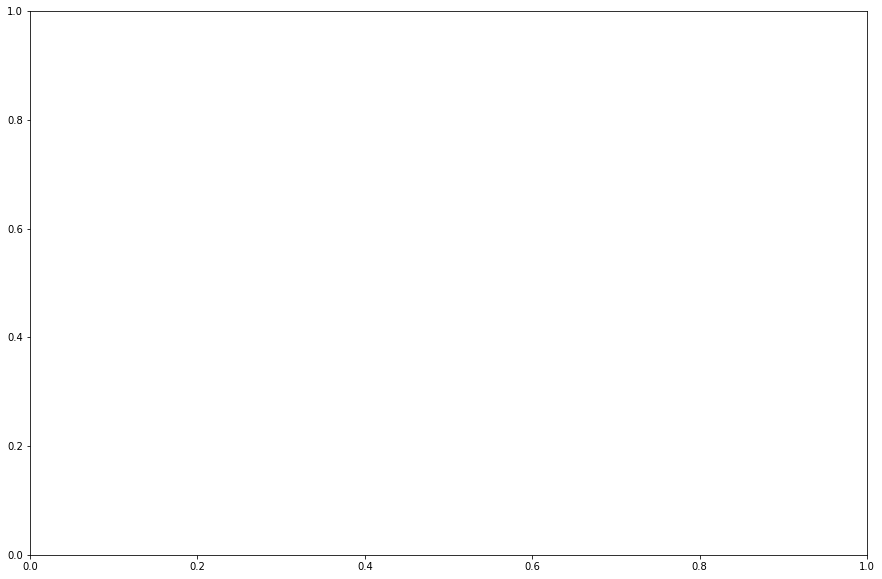

In [35]:
# OPTION
# y-axis can also use data.column.rolling().mean() to smooth out peaks

# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(15, 10))
# make a plot with activeadd obj
ax.plot(data.index, data.activeAddresses, color="red")
# set x-axis label
ax.set_xlabel("datetime",fontsize=10)
# set y-axis label
ax.set_ylabel("active addresses",color="red",fontsize=15)
ax.legend(loc='upper left')

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using price obj
ax2.plot(data.index, data.priceUsd,color="blue")
ax2.set_ylabel("price USD",color="blue",fontsize=15)
ax2.legend(loc='upper right')
plt.show()

In [38]:
data.dtypes

chainlink_activeAddresses           float64
chainlink_activeDepositAddresses    float64
priceUsd                            float64
volume                              float64
dtype: object

In [36]:
import numpy as np

x = data['chainlink_activeAddresses']
y = data['priceUsd']

# polynomial fit
# returns the polynomial coefficients that minimize the square error 
fit = np.polyfit(x,y,1)
fit

array([0.00083007, 0.68529163])

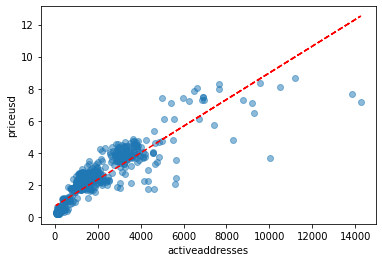

In [37]:
# scatter plot of addresses to price

import numpy as np

x = data['chainlink_activeAddresses']
y = data['priceUsd']

plt.scatter(x, y, alpha=0.5)
plt.xlabel('activeaddresses')
plt.ylabel('priceusd')

# plot trendline/regression fit line of variable relationship
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

In [ ]:
# get r squared of variables

from sklearn.metrics import r2_score

plt.plot(x,y,"+", ms=10, mec="k")
plt.xlabel('activeaddresses')
plt.ylabel('priceusd')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)(x)

plt.plot(x, p, "r--")
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

In [39]:
# in other words, above model defined as

from scipy import stats
from numpy import sqrt

x = data['chainlink_activeAddresses']
y = data['priceUsd']

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope:", slope,
      "\nintercept:", intercept,
      "\nr squared:", r_value**2,
      "\np_value:", p_value,
      "\nst_error:", std_err,      
      "\nRMSE", sqrt(std_err))

#R squared of .81: This tells us that the linear regression model explains 81% of the variablility found in the data.


slope: 0.0008300667299334836 
intercept: 0.6852916337985098 
r squared: 0.8131037321429317 
p_value: 1.0319227987241769e-267 
st_error: 1.4739290558667605e-05 
RMSE 0.0038391783702593977


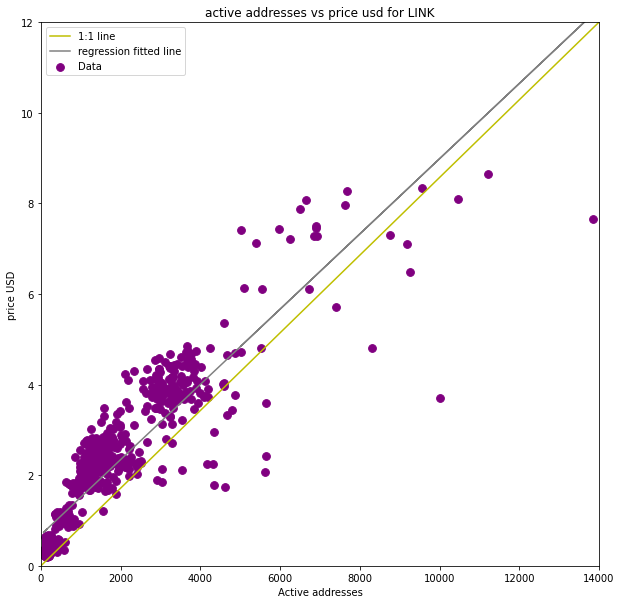

In [40]:
# Compare with perfect 1:1 fit

# Create scatter plot
fig, ax = plt.subplots(figsize=(10, 10))

m = slope.astype(float)

data.plot('chainlink_activeAddresses', 'priceUsd',
                          kind='scatter', color="purple",
                          s=60, ax=ax, label="Data")

# Add a diagonal line
ax.set(xlim=[0, 14000], ylim=[0, 12])
ax.plot((0, 1), (0, 1), 'y-', transform=ax.transAxes, label="1:1 line")
ax.plot(x, m*x + intercept, 'grey', label='regression fitted line')

ax.set(xlabel="Active addresses",
       ylabel="price USD", title="active addresses vs price usd for LINK")
plt.legend()

In [ ]:
import matplotlib
matplotlib.axes.Axes.scatter
matplotlib.pyplot.scatter

In [ ]:
plt.plot?

In [ ]:
plt.scatter?

In [ ]:
matplotlib.markers?